This is a workbook to play around with visualizing my data set.

In [1]:
'''This is my setup block.'''
from sqlalchemy import create_engine #SQL
from sqlalchemy_utils import database_exists, create_database #SQL
import psycopg2 #SQL
import pandas as pd #SQL, python

import numpy as np #plots
import matplotlib.pyplot as plt #plots
#import seaborn as sns #plots

import pickle #for saving off a trained model

import time #python
from datetime import date
start = time.mktime(time.localtime())

%matplotlib inline


dbname = 'steamspy'
username = 'alan'
engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))

#seed = np.random.randint(0,high=10000)
seed=6072
print("random seed:",seed)

random seed: 6072


This next section handles my database calls. I also want to remove "free" games from my dataset, since they (presumably) use a different revenue model for which I can't get data. The reporting numbers are just a sanity check to see how many titles I pull out. Right now, they're about 7500, which is enough to make me reasonably happy I can do something with the data.

In [2]:
#pull from DB:steamspy TABLE:indie_demo
#do some data preprocessing to create a usable pandas dataframe that I can feed into sklearn

'''pull all of my pre-processed indie data'''
sql_query = '''SELECT * FROM indie_demo;'''
indies = pd.read_sql_query(sql_query,engine)
indies.fillna(value=0,inplace=True)

print("indies:",len(indies)) #debug: how many records did I pull?
#list(indies)

indies: 7573


(0, 1500)

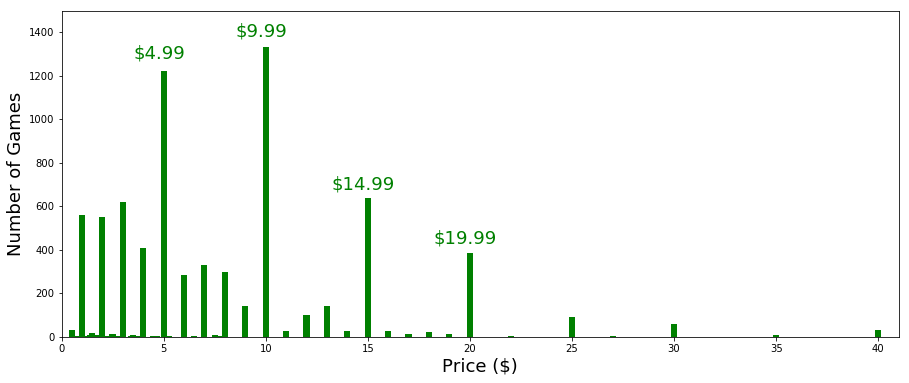

In [3]:
#Let's do some data exploration with matplotlib.pyplot as plt
count_prices = indies['price'].value_counts().sort_index()
count_df = pd.DataFrame({'price':count_prices.index, 'count':count_prices.values})
plt.rcParams["figure.figsize"] = [15,6]

fig,ax = plt.subplots()
ax.patch.set_visible(True)
fig.patch.set_visible(True)
#ax.patch.set_facecolor('None')
fig.patch.set_facecolor('None')

ax.set_xlabel('Price ($)', fontsize = '18')
ax.set_ylabel('Number of Games', fontsize = '18')

#ax.set_title('Number of titles by Price', fontsize = '24')

plt.bar(count_df['price'],count_df['count'],width=0.3, color="green")
plt.annotate("$4.99", (3.5,1280), color="green", fontsize='18')
plt.annotate("$9.99", (8.5,1380), color="green", fontsize='18')
plt.annotate("$14.99", (13.2,680), color="green", fontsize='18')
plt.annotate("$19.99", (18.2,430), color="green", fontsize='18')

plt.xlim([0,41])
plt.ylim([0,1500])

(0, 9)

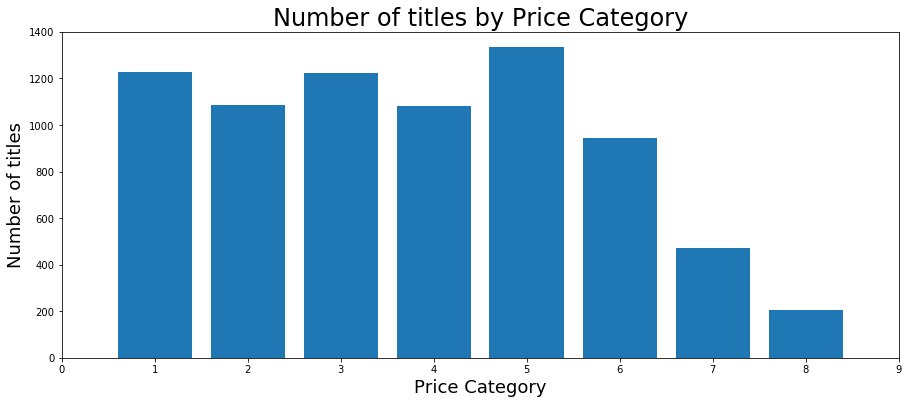

In [5]:
#pricemap is a category mapping for prices
#$0-$5 is category 1, etc.
#pricemap = {30:6,25:5,20:4,15:3,10:2,5:1} #should be descending
pricemap = {20.0:7,
            15.0:6,
            10.0:5,
            9.9:4,
            5.0:3,
            4.9:2,
            2.0:1}

def price_cat(price):
    category = len(pricemap) + 1
    for cap in pricemap:
        if float(price) < cap:
            category = pricemap[cap]
    return(category)

indie_cat = pd.DataFrame(indies['price'].apply(price_cat))
indie_cat['appid'] = indies['appid']
indie_cat.rename(columns={'price': 'price_category'}, inplace=True)
#print(indie_cat)

#Let's do some data exploration with matplotlib.pyplot as plt

count_prices = indie_cat['price_category'].value_counts().sort_index()
count_df = pd.DataFrame({'price_category':count_prices.index, 'count':count_prices.values})
plt.rcParams["figure.figsize"] = [15,6]

fig,ax = plt.subplots()
ax.set_xlabel('Price Category', fontsize = '18')
ax.set_ylabel('Number of titles', fontsize = '18')

ax.set_title('Number of titles by Price Category', fontsize = '24')

plt.bar(count_df['price_category'],count_df['count'],width=0.8)

plt.xlim([0,len(pricemap) + 2])

Done!


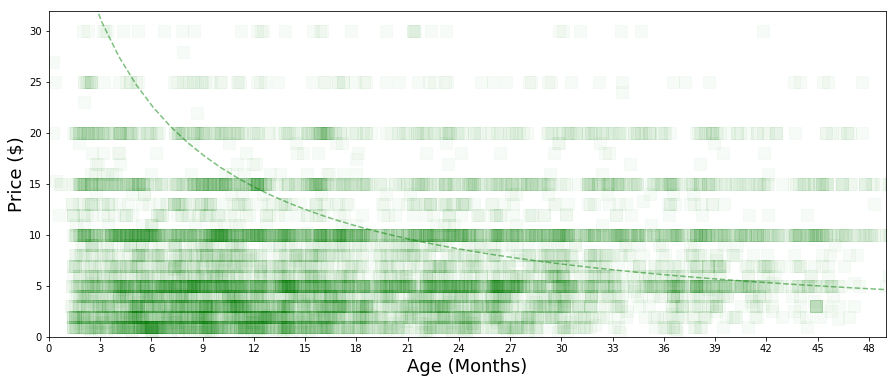

In [6]:
#Let's do some data exploration with matplotlib.pyplot as plt
today_seconds=((date(2017,8,1)-date(1970,1,1)).total_seconds())

def to_age(seconds):
    #return((today_seconds-seconds)/86400) #days
    return((today_seconds-seconds)/2628000) #months
    
#indie_release = indies['release'].value_counts().sort_index()
release_df = pd.DataFrame(indies['release_mo_sec'].apply(to_age))
release_df['price'] = indies['price']
release_df = release_df[release_df['release_mo_sec']!=today_seconds]
#print(release_df) #debug


plt.rcParams["figure.figsize"] = [15,6]

fig,ax = plt.subplots()
ax.set_xlabel('Age (Months)', fontsize = '18')
ax.set_ylabel('Price ($)', fontsize = '18')

#ax.set_title('Price by Age', fontsize = '24')

#plt.xlim([0,3e8])
#plt.xlim([0,1460]) #days
plt.xlim([0,49]) #months
plt.ylim([0,32])

plt.xticks(np.arange(0, 49, 3.0))

#plt.plot(np.arange(1,1400),3000/np.arange(1,1400), color="green", linestyle="--", alpha=.5) #this is arbitrary
plt.plot(np.arange(.1,55)-5,250/np.arange(.1,55), color="green", linestyle="--", alpha=.5) #this is arbitrary

#plt.annotate("What you might expect", (5,27), color="green", fontsize='24')
plt.scatter(release_df['release_mo_sec'],release_df['price'], color="green", marker="s", alpha=0.03,s=150)

#plt.pcolor

#let's try a heatmap
#sns.heatmap([release_df['release_mo_sec'], release_df['price']], annot=True, fmt="d")
print("Done!")

In [9]:
import seaborn as sns

In [12]:
release_df.head(2)

,release_mo_sec,price
0,141.731507,9.99
1,72.460274,9.99


In [19]:
histo2d = np.histogram2d(release_df.release_mo_sec.values,release_df.price.values,bins=500)

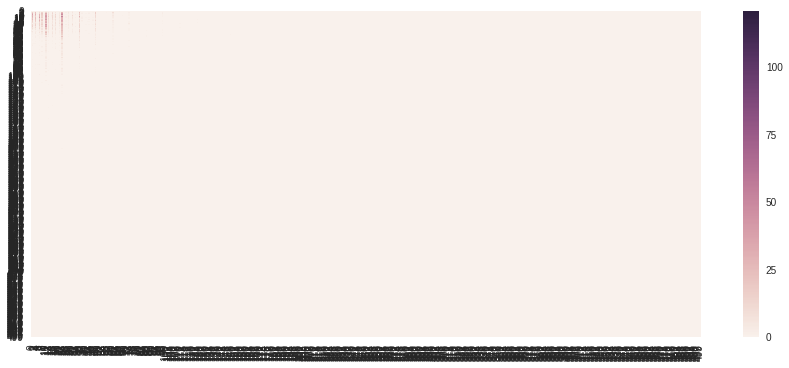

In [25]:
sns.heatmap(histo2d[0])

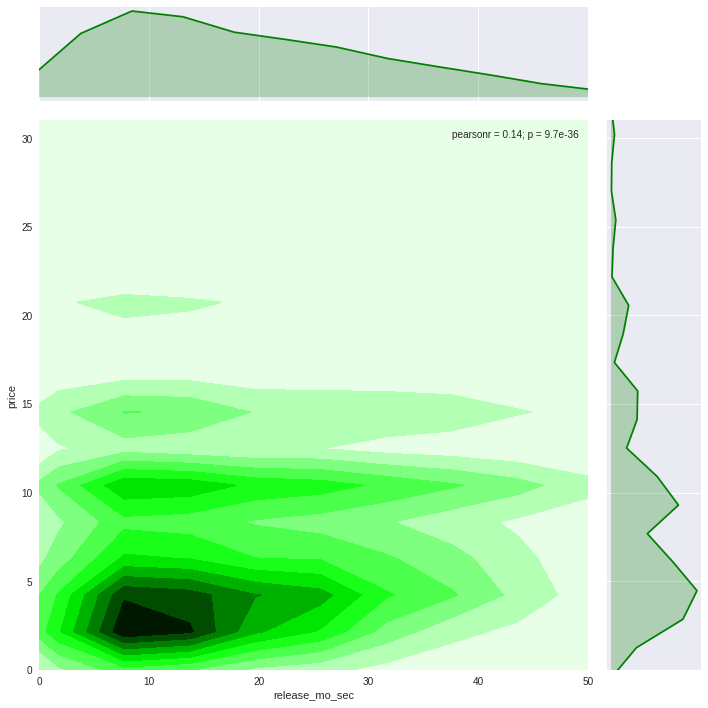

In [12]:
import seaborn as sns
plt.figure(figsize=(5,5))
#ax = sns.jointplot(x='release_mo_sec',y='price',data=release_df,kind='kde',size=10,color='black', xlim=[0,50],ylim=[0,31])
ax = sns.jointplot(x='release_mo_sec',y='price',data=release_df,kind='kde',size=10,color='black', xlim=[0,50],ylim=[0,31])


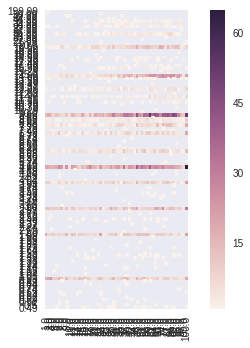

In [8]:
#transform 2-col dataframes so I can put them into a heatmap
def heatmap_t(df):
    out_dict = {}
    for row in range(len(df)):
        rating = df.iloc[row,0]
        price = df.iloc[row,1]
        if rating not in out_dict:
            out_dict[rating] = {}
        if price in out_dict[rating]:
            out_dict[rating][price] += 1
        else:
            out_dict[rating][price] = 1
    out_df = pd.DataFrame.from_dict(out_dict)
    #print(out_df)
    return(out_df)

rating_df = pd.DataFrame(indies['score_rank'])
rating_df['price'] = indies['price']
rating_df = rating_df[rating_df['score_rank']>0]
heat_df = heatmap_t(rating_df)
#print(heat_df)
#look up np.hist() for 2d

#plt.box(heat_df)

#let's try a heatmap
#import seaborn as sns
ax = sns.heatmap(heat_df,square=True)

ax.invert_yaxis()


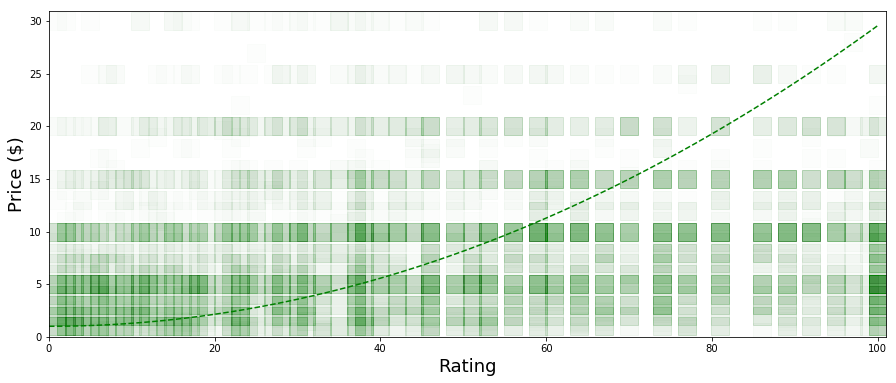

In [22]:
#Let's do some data exploration with matplotlib.pyplot as plt
rating_df = pd.DataFrame(indies['score_rank'])
rating_df['price'] = indies['price']
rating_df = rating_df[rating_df['score_rank']>0]


#print(rating_df)
plt.rcParams["figure.figsize"] = [15,6]

fig,ax = plt.subplots()
ax.set_xlabel('Rating', fontsize = '18')
ax.set_ylabel('Price ($)', fontsize = '18')

#ax.set_title('Price by Rating', fontsize = '24')

plt.xlim([0,101])
plt.ylim([0,31])

plt.plot(np.arange(0,101),(np.arange(0,101)*np.arange(0,101)/350)+1, linestyle="--", color="green", alpha=1) #this is arbitrary
plt.scatter(rating_df['score_rank'],rating_df['price'],color="green", marker="s",alpha=0.01,s=300)

#plt.annotate("What you might expect", (57,27), color="green", fontsize='24')


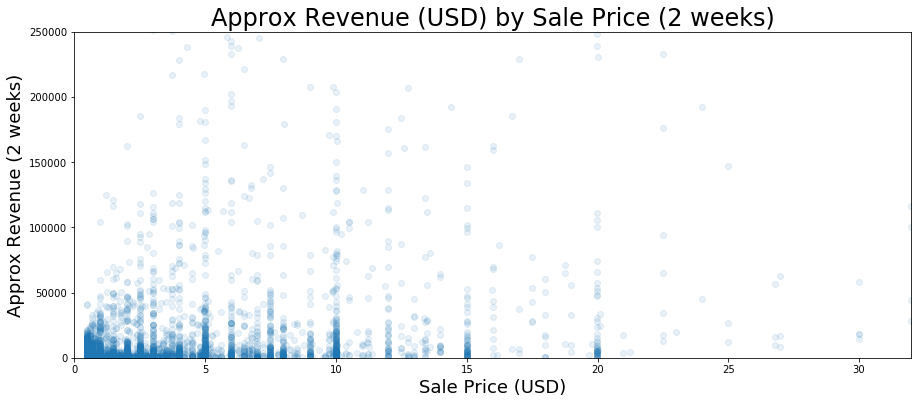

In [8]:
#Let's do some data exploration with matplotlib.pyplot as plt
revenue_df = pd.DataFrame(indies['saleprice']*indies['newowners'])
revenue_df.rename(columns={0: 'revenue'}, inplace=True)
revenue_df['saleprice'] = indies['saleprice']
revenue_df = revenue_df[revenue_df['revenue']>0]

#print(revenue_df)
plt.rcParams["figure.figsize"] = [15,6]

fig,ax = plt.subplots()
ax.set_xlabel('Sale Price (USD)', fontsize = '18')
ax.set_ylabel('Approx Revenue (2 weeks)', fontsize = '18')

ax.set_title('Approx Revenue (USD) by Sale Price (2 weeks)', fontsize = '24')

plt.xlim([0,32])
plt.ylim([0,250000])

plt.scatter(revenue_df['saleprice'],revenue_df['revenue'],alpha=0.1)



Now I have a dataframe that I can put into a model, so go ahead and use sklearn to do that.

Here's some sample code for a decision tree with multiple outputs. http://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression_multioutput.html

In [37]:
finish = time.mktime(time.localtime())
runtime = finish - start
print("Finished processing in",runtime,"seconds!")

Finished processing in 36.0 seconds!
